# Named Entity Recognition

## Data Loading and Preparing

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

### Loading data

In [2]:
DATA_PATH = "Data/ner_dataset.csv"

df = pd.read_csv(DATA_PATH, engine='python')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

Tha dataset has many nan values, but these indicate that each word in the row belong to the last sentence number in `Sentence #` column. We will use forward fill method to remove nan values and have a clear indication as to which sentence does the word belong.

In [4]:
df = df.fillna(method = 'ffill')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


Now, we can create groups in the dataframe by the `Sentence #` column. Each group will contain a single sentence.

In [5]:
group = df.groupby("Sentence #")

#### Creating sentences from groups
With the dataset distributed into groups, we can iterarte each group to form a complete sentence and their corresponding tags from the `Word` and `Tag` column.

In [6]:
sample = group.groups['Sentence: 1']

sent = df.iloc[sample].Word.values
tags = df.iloc[sample].Tag.values

print("The sentence words and tags are")
for item in zip(sent, tags):
    print(item)

The sentence words and tags are
('Thousands', 'O')
('of', 'O')
('demonstrators', 'O')
('have', 'O')
('marched', 'O')
('through', 'O')
('London', 'B-geo')
('to', 'O')
('protest', 'O')
('the', 'O')
('war', 'O')
('in', 'O')
('Iraq', 'B-geo')
('and', 'O')
('demand', 'O')
('the', 'O')
('withdrawal', 'O')
('of', 'O')
('British', 'B-gpe')
('troops', 'O')
('from', 'O')
('that', 'O')
('country', 'O')
('.', 'O')


Using the above code over all groups and creating 2 lists,
- `all_sent` : list of list containing words for each sentence as a list
- `all_tags` : list of list containing tags for each word in sentence as a list

In [7]:
all_sent = []
all_tags = []

done = 0

for sent_num, indices in group.groups.items():
    sentence = df.iloc[indices].Word.values.tolist()
    tags = df.iloc[indices].Tag.values.tolist()
    all_sent.append(sentence)
    all_tags.append(tags)
    
    done += 1
    
    if(done % 500 == 0):
        print(f"Processed {done} sentences", end='\r')
        
print(f"Total Number of sentences : {done}")

Total Number of sentences : 47959


In [8]:
X_train, X_test, y_train, y_test = train_test_split(all_sent, all_tags, test_size=0.2)

In [9]:
print(f"""Train set size : {len(X_train)}
Test set size : {len(X_test)}""")

Train set size : 38367
Test set size : 9592


### Building vocabulary
Now we have our train and test sets, we can create vocabulary for both our sentences and tags. We are going to add 3 extra tokens in our vocabularies. These are,
- `<unk>` : Used to replace words not in the vocabulary
- `<pad>` : Used to pad sentences to form batchs
- `<pad_tag>` : Used to pad tags for sentences, helps us to not consider padded tokens when computing metrics

In [10]:
word_counter = Counter()
tag_counter = Counter()

for sent in X_train:
    word_counter.update(sent)
    
for tag in all_tags:
    tag_counter.update(tag)

In [11]:
PAD = 0
UNK = 1
PAD_TAG = -1

vocab = {'<unk>' : UNK, '<pad>' : PAD}
for i, (word, cnt) in enumerate(word_counter.items()):
    vocab[word] = i + 2
    
tags = {'<pad_tag>' : PAD_TAG}
for i, (t, c) in enumerate(tag_counter.items()):
    tags[t] = i

In [12]:
print(f"Number of words in vocabulary : {len(vocab)}")
print(f"Number of tags in vocabulary : {len(tags)}")

Number of words in vocabulary : 32073
Number of tags in vocabulary : 18


### Plotting distribution of tags

In [13]:
import matplotlib.pyplot as plt

<BarContainer object of 17 artists>

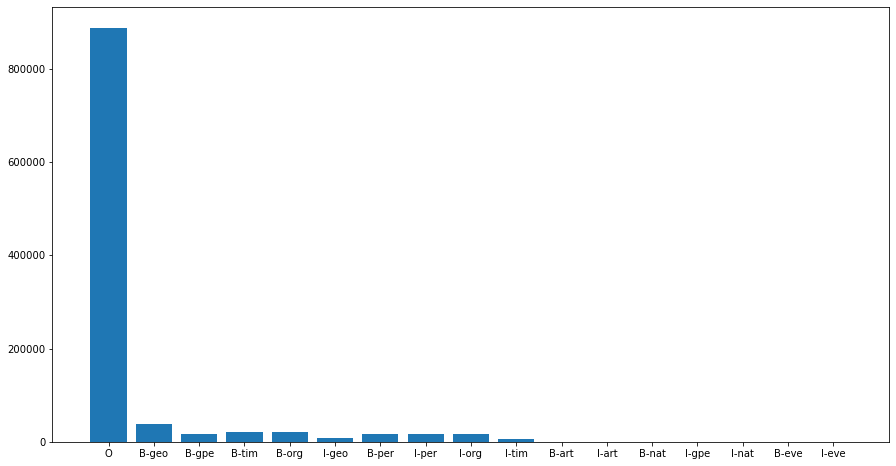

In [14]:
fig = plt.figure(figsize=(15, 8))
plt.bar(tag_counter.keys(), tag_counter.values())

Without filler token `O`

<BarContainer object of 16 artists>

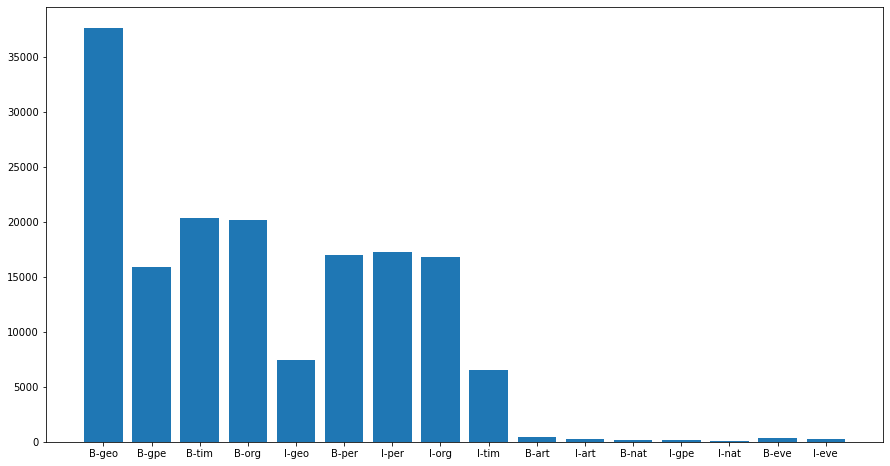

In [15]:
tc = tag_counter
del(tc['O'])

fig = plt.figure(figsize=(15, 8))

plt.bar(tc.keys(), tc.values())

Now we have our dataset and vocabulary ready, we can move on to build our data loader and then the NER network.